# Introduction

In the below training we will pick up where we left off in the EDA notebook exploring a synthetic dataset for a hypothetical phone and internet service, InterConnect. We are looking at user service and demographic data and hoping to be able to predict which users will churn (discontinue service). Churn tasks are classic among machine learning tasks because most every company will want to know which of their users or clients are at risk of leaving, so they may be targeted with coupons and promotional services to prevent churn.

Below we will first do our final preparation of the data, splitting it into two dataframes -- one with encoding for decision tree based classification models, and one with encoding for gradient boosting models that prefer ordinal encoding. Then we will train our models via a cross validation grid search to arrive at the optimal hyperparameters for this dataset, and evaluate their performances.

**As a reminder from the EDA notebook, our target feature is whether a given user churned, which was True when the 'EndDate' column value was equal to anything but 'No'. We no longer have the 'EndDate' feature but rather have our target feature 'Churned'.**

## Initialize Libraries and First Looks at Dataframe

In [1]:
# Statistical libraries
import pandas as pd
import numpy as np

# Machine Learning libraries
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

# Graphing libraries
from matplotlib import pyplot as plt

In [2]:
# Read Dataframe
df = pd.read_csv('./datasets/preprocessed_output.csv', index_col=[0]) #See EDA notebook for preprocessing & EDA

# Quick look at df and numeric/categorical features
df.info()
display(df.sample(10, random_state=12345))

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
 9   gender            7043 non-null   bool   
 10  Partner           7043 non-null   bool   
 11  Dependents        7043 non-null   bool   
 12  InternetService   7043 non-null   bool   
 13  OnlineSecurity    7043 non-null   bool   
 14  OnlineBackup      7043 non-null   bool   
 15  DeviceProtection  7043 non-null   bool   
 16  TechSupport       7043 non-null   bool   
 17  

customerID            Type  PaperlessBilling              PaymentMethod  \
1128  0098-BOWSO  Month-to-month              True           Electronic check   
2875  9992-RRAMN  Month-to-month              True           Electronic check   
1783  8380-PEFPE  Month-to-month              True           Electronic check   
3804  9773-PEQBZ  Month-to-month             False           Electronic check   
6087  8319-QBEHW        One year              True  Bank transfer (automatic)   
2071  3392-EHMNK        Two year             False    Credit card (automatic)   
2395  6486-LHTMA        One year              True           Electronic check   
4660  0883-EIBTI  Month-to-month             False               Mailed check   
372   6122-EFVKN        Two year             False               Mailed check   
1143  2446-ZKVAF  Month-to-month             False    Credit card (automatic)   

      MonthlyCharges  TotalCharges  Churned  DaysCustomer  ChurnSeasonality  \
1128           19.40        529.80    False           822         -0.003225   
2875           85.10       1873.70     True           668          0.475599   
1783           71.65         71.65     True            30          0.869764   
3804           79.85        797.25    False           306          0.524010   
6087           39.95       1023.75    False           792          0.490660   
2071           94.10       6302.80    False          2041         -0.851148   
2395           90.70       2835.50    False           945         -0.853398   
4660           19.50         31.55     True            61          0.498137   
372            35.75        830.80    False           730          0.999963   
1143           56.80       1074.65    False           549         -0.999813   

      gender  ...  OnlineSecurity  OnlineBackup  DeviceProtection  \
1128   False  ...           False         False             False   
2875   False  ...           False         False             False   
1783   False  ...           False         False             False   
3804   False  ...           False          True             False   
6087   False  ...           False          True             False   
2071    True  ...           False          True             False   
2395    True  ...           False         False              True   
4660    True  ...           False         False             False   
372    False  ...            True         False             False   
1143   False  ...           False          True             False   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False        False             True           True         True   
1783        False        False            False          False         True   
3804        False        False            False           True         True   
6087        False         True            False          False         True   
2071         True         True            False           True         True   
2395        False         True            False           True         True   
4660        False        False            False          False        False   
372          True        False            False          False         True   
1143        False        False            False           True         True   

      HasPhone  NotChurned  
1128      True        True  
2875      True       False  
1783      True       False  
3804      True        True  
6087     False        True  
2071      True        True  
2395      True        True  
4660      True       False  
372      False        True  
1143      True        True  

[10 rows x 23 columns]

## Final Preprocessing and Feature Split
You can see from the above table that we have some cleaning and encoding to do now that we are to feed the dataframe into some classification models. We also need to split the data into training, validation, and test sets, and scale numeric features. To make sure numeric and categorical features work best across every model without rescaling or reprocessing the dataframe, we will aim for values centered around 0 between -1 and 1 for ALL features.

Let's look at a sample of the non-boolean features:

In [3]:
display(df[['customerID', 'Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DaysCustomer', 'ChurnSeasonality']].sample(10, random_state=12345))

customerID            Type              PaymentMethod  MonthlyCharges  \
1128  0098-BOWSO  Month-to-month           Electronic check           19.40   
2875  9992-RRAMN  Month-to-month           Electronic check           85.10   
1783  8380-PEFPE  Month-to-month           Electronic check           71.65   
3804  9773-PEQBZ  Month-to-month           Electronic check           79.85   
6087  8319-QBEHW        One year  Bank transfer (automatic)           39.95   
2071  3392-EHMNK        Two year    Credit card (automatic)           94.10   
2395  6486-LHTMA        One year           Electronic check           90.70   
4660  0883-EIBTI  Month-to-month               Mailed check           19.50   
372   6122-EFVKN        Two year               Mailed check           35.75   
1143  2446-ZKVAF  Month-to-month    Credit card (automatic)           56.80   

      TotalCharges  DaysCustomer  ChurnSeasonality  
1128        529.80           822         -0.003225  
2875       1873.70           668          0.475599  
1783         71.65            30          0.869764  
3804        797.25           306          0.524010  
6087       1023.75           792          0.490660  
2071       6302.80          2041         -0.851148  
2395       2835.50           945         -0.853398  
4660         31.55            61          0.498137  
372         830.80           730          0.999963  
1143       1074.65           549         -0.999813

### Cleaning and encoding
In the EDA notebook, we observed that when it came to contract type, user behavior deviated the most when users were on a month-to-month contract. It is also inherently short term, while one year and two year contracts are almost a category of contract of their own. When encoding these types to numeric values, it would not make sense to use an arithmetic or ordinal series such as 1, 2, and 3. We have an opportunity to make the encoded numbers reflect how similar one year and two year contracts are, and separate month-to-month values. Engineering the feature in this manner attempts to pass these relationships into the model, and aims to enhance performance over one-hot encoding.

But first, we can drop the customerID column as it is irrelevent to model training. We can also drop the 'NotChurned' column as it was used purely for EDA purposes, and more importantly as it is the inverse of our target feature, we CANNOT let it pass into models.

We will create two different dataframes -- one that is one-hot encoded or custom encoded for classic models, and one that preserves ordinally-split categories for our gradient boosting model.

In [4]:
# Drop customerID col
df = df.drop(['customerID', 'NotChurned'], axis=1)

# Make copy for the sake of the gradient boosting model
df_gbm = df.copy()

#### The 'Type' Column

In [5]:
# Encode 'Type' column to between -1 and 1
type_to_numeric = {
    'Month-to-month' : -1,
    'One year' : .5, 
    'Two year' : 1
}

df.replace({'Type': type_to_numeric}, inplace=True)
df['Type'] = df['Type'].astype('float64')

# Ordinally encode 'Type' column
type_to_ordinal = {
    'Month-to-month' : 1,
    'One year' : 2, 
    'Two year' : 3
}
df_gbm.replace({'Type': type_to_ordinal}, inplace=True)
df_gbm['Type'] = df_gbm['Type'].astype('int64')

C:\Users\brian\AppData\Local\Temp\ipykernel_10096\1703678482.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Type': type_to_numeric}, inplace=True)
C:\Users\brian\AppData\Local\Temp\ipykernel_10096\1703678482.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gbm.replace({'Type': type_to_ordinal}, inplace=True)


#### The 'PaymentMethod' Column

In [6]:
# One-Hot Encode (OHE) 'PaymentMethod' column
df_ohe = pd.get_dummies(df['PaymentMethod'])
display(df_ohe.sample(10, random_state=12345))
df = df.drop('PaymentMethod', axis=1)
df = pd.concat([df, df_ohe], axis=1)

# Ordinally encode 'PaymentMethod' column
payment_to_ordinal = {
    'Bank transfer (automatic)' : 1,
    'Credit card (automatic)' : 2, 
    'Electronic check' : 3,
    'Mailed check' : 4
}
df_gbm.replace({'PaymentMethod': payment_to_ordinal}, inplace=True)
df_gbm['PaymentMethod'] = df_gbm['PaymentMethod'].astype('int64')

Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
1128                      False                    False              True   
2875                      False                    False              True   
1783                      False                    False              True   
3804                      False                    False              True   
6087                       True                    False             False   
2071                      False                     True             False   
2395                      False                    False              True   
4660                      False                    False             False   
372                       False                    False             False   
1143                      False                     True             False   

      Mailed check  
1128         False  
2875         False  
1783         False  
3804         False  
6087         False  
2071         False  
2395         False  
4660          True  
372           True  
1143         False

C:\Users\brian\AppData\Local\Temp\ipykernel_10096\401535105.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gbm.replace({'PaymentMethod': payment_to_ordinal}, inplace=True)


In [7]:
# Check our work before scaling
display(df.sample(10, random_state=12345))

Type  PaperlessBilling  MonthlyCharges  TotalCharges  Churned  \
1128  -1.0              True           19.40        529.80    False   
2875  -1.0              True           85.10       1873.70     True   
1783  -1.0              True           71.65         71.65     True   
3804  -1.0             False           79.85        797.25    False   
6087   0.5              True           39.95       1023.75    False   
2071   1.0             False           94.10       6302.80    False   
2395   0.5              True           90.70       2835.50    False   
4660  -1.0             False           19.50         31.55     True   
372    1.0             False           35.75        830.80    False   
1143  -1.0             False           56.80       1074.65    False   

      DaysCustomer  ChurnSeasonality  gender  Partner  Dependents  ...  \
1128           822         -0.003225   False    False       False  ...   
2875           668          0.475599   False     True       False  ...   
1783            30          0.869764   False    False        True  ...   
3804           306          0.524010   False    False       False  ...   
6087           792          0.490660   False    False        True  ...   
2071          2041         -0.851148    True     True        True  ...   
2395           945         -0.853398    True     True       False  ...   
4660            61          0.498137    True    False       False  ...   
372            730          0.999963   False    False        True  ...   
1143           549         -0.999813   False     True       False  ...   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False        False             True           True         True   
1783        False        False            False          False         True   
3804        False        False            False           True         True   
6087        False         True            False          False         True   
2071         True         True            False           True         True   
2395        False         True            False           True         True   
4660        False        False            False          False        False   
372          True        False            False          False         True   
1143        False        False            False           True         True   

      HasPhone  Bank transfer (automatic)  Credit card (automatic)  \
1128      True                      False                    False   
2875      True                      False                    False   
1783      True                      False                    False   
3804      True                      False                    False   
6087     False                       True                    False   
2071      True                      False                     True   
2395      True                      False                    False   
4660      True                      False                    False   
372      False                      False                    False   
1143      True                      False                     True   

      Electronic check  Mailed check  
1128              True         False  
2875              True         False  
1783              True         False  
3804              True         False  
6087             False         False  
2071             False         False  
2395              True         False  
4660             False          True  
372              False          True  
1143             False         False  

[10 rows x 24 columns]

### Splitting and Scaling Data
We will split the data on a 3:1:1 ratio for training, validation, and testing. We have 7,043 total rows, so we are looking at using a training set of about 4,226 rows.

In [8]:
# Separate dataframes into features and targets and randomize using train_test_split
features = df.drop(['Churned'], axis=1)
target = df['Churned']

features_gbm = df_gbm.drop(['Churned'], axis=1)
target_gbm = df_gbm['Churned']

# Split data to make train and test sets in ratio of 4:1 (KFold will further divide training set into validation set)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_gbm_train, features_gbm_test, target_gbm_train, target_gbm_test = train_test_split(features_gbm, target_gbm, test_size=0.2, random_state=12345)

The 'MonthlyCharges', 'TotalCharges', and 'DaysCustomer' features do not appear have outliers or exceptional distributions which might merit specialty rescaling techniques (see EDA). Therefore, we will use a simple scaling technique to place all three of these features in approximately the -1 to 1 range with a mean of 0 and unit distribution of 0. Models perform best with similarly-scaled feature ranges.

'ChurnSeasonality' is an engineered feature that attempts to capture what time of year users churn service. While its mean is not 0 (see EDA), its distribution is already between -1 and 1, and rescaling the feature would change the underlying sinusoidal seasonality. We will leave this feature as-is.

In [9]:
# Scale numeric to approx. between -1 and 1, mean and unit distr. = 0
from sklearn.preprocessing import StandardScaler
scale_features = ['MonthlyCharges', 'TotalCharges', 'DaysCustomer']

# Standardizing each feature's scaling is very important when features differ by any order of magnitude
ss = StandardScaler()
ss.fit(features_train[scale_features])
features_train[scale_features] = ss.transform(features_train[scale_features])
features_test[scale_features] = ss.transform(features_test[scale_features])
features_gbm_train[scale_features] = ss.transform(features_train[scale_features])
features_gbm_test[scale_features] = ss.transform(features_test[scale_features])

In [10]:
# Check our work
display(df.sample(10, random_state=12345))
display(df_gbm.sample(10, random_state=12345))

Type  PaperlessBilling  MonthlyCharges  TotalCharges  Churned  \
1128  -1.0              True           19.40        529.80    False   
2875  -1.0              True           85.10       1873.70     True   
1783  -1.0              True           71.65         71.65     True   
3804  -1.0             False           79.85        797.25    False   
6087   0.5              True           39.95       1023.75    False   
2071   1.0             False           94.10       6302.80    False   
2395   0.5              True           90.70       2835.50    False   
4660  -1.0             False           19.50         31.55     True   
372    1.0             False           35.75        830.80    False   
1143  -1.0             False           56.80       1074.65    False   

      DaysCustomer  ChurnSeasonality  gender  Partner  Dependents  ...  \
1128           822         -0.003225   False    False       False  ...   
2875           668          0.475599   False     True       False  ...   
1783            30          0.869764   False    False        True  ...   
3804           306          0.524010   False    False       False  ...   
6087           792          0.490660   False    False        True  ...   
2071          2041         -0.851148    True     True        True  ...   
2395           945         -0.853398    True     True       False  ...   
4660            61          0.498137    True    False       False  ...   
372            730          0.999963   False    False        True  ...   
1143           549         -0.999813   False     True       False  ...   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False        False             True           True         True   
1783        False        False            False          False         True   
3804        False        False            False           True         True   
6087        False         True            False          False         True   
2071         True         True            False           True         True   
2395        False         True            False           True         True   
4660        False        False            False          False        False   
372          True        False            False          False         True   
1143        False        False            False           True         True   

      HasPhone  Bank transfer (automatic)  Credit card (automatic)  \
1128      True                      False                    False   
2875      True                      False                    False   
1783      True                      False                    False   
3804      True                      False                    False   
6087     False                       True                    False   
2071      True                      False                     True   
2395      True                      False                    False   
4660      True                      False                    False   
372      False                      False                    False   
1143      True                      False                     True   

      Electronic check  Mailed check  
1128              True         False  
2875              True         False  
1783              True         False  
3804              True         False  
6087             False         False  
2071             False         False  
2395              True         False  
4660             False          True  
372              False          True  
1143             False         False  

[10 rows x 24 columns]

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
1128     1              True              3           19.40        529.80   
2875     1              True              3           85.10       1873.70   
1783     1              True              3           71.65         71.65   
3804     1             False              3           79.85        797.25   
6087     2              True              1           39.95       1023.75   
2071     3             False              2           94.10       6302.80   
2395     2              True              3           90.70       2835.50   
4660     1             False              4           19.50         31.55   
372      3             False              4           35.75        830.80   
1143     1             False              2           56.80       1074.65   

      Churned  DaysCustomer  ChurnSeasonality  gender  Partner  ...  \
1128    False           822         -0.003225   False    False  ...   
2875     True           668          0.475599   False     True  ...   
1783     True            30          0.869764   False    False  ...   
3804    False           306          0.524010   False    False  ...   
6087    False           792          0.490660   False    False  ...   
2071    False          2041         -0.851148    True     True  ...   
2395    False           945         -0.853398    True     True  ...   
4660     True            61          0.498137    True    False  ...   
372     False           730          0.999963   False    False  ...   
1143    False           549         -0.999813   False     True  ...   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
1128            False           False         False             False   
2875             True           False         False             False   
1783             True           False         False             False   
3804             True           False          True             False   
6087            False           False          True             False   
2071             True           False          True             False   
2395             True           False         False              True   
4660            False           False         False             False   
372             False            True         False             False   
1143            False           False          True             False   

      TechSupport  StreamingTV  StreamingMovies  MultipleLines  HasInternet  \
1128        False        False            False          False        False   
2875        False        False             True           True         True   
1783        False        False            False          False         True   
3804        False        False            False           True         True   
6087        False         True            False          False         True   
2071         True         True            False           True         True   
2395        False         True            False           True         True   
4660        False        False            False          False        False   
372          True        False            False          False         True   
1143        False        False            False           True         True   

      HasPhone  
1128      True  
2875      True  
1783      True  
3804      True  
6087     False  
2071      True  
2395      True  
4660      True  
372      False  
1143      True  

[10 rows x 21 columns]

Our dataframe is finalized and ripe for passing into models.

## Model Training

We will be training two classification models before diving into a classic gradient boosting model, LightGBMClassifier(). For all models we will set up a KFold cross-validation and use a grid pipeline to optimize hyperparameters based on f1-score.

### Initializing libraries and Helper Functions

In [11]:
# Machine Learning libraries
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# I/O libraries
import pickle
import json

The below definition is a helper function for any classification model with .fit() and .predict() methods. It can return a dictionary of evaluation metrics, as well as the trained model if return_model is set to False.

In [12]:
def eval_model(model_name, model, X, y, Xtest, ytest, fit_params={}, return_model=False, verbose=0):
    '''
    This function takes as parameters the kind of model being used (str), an untrained model object, 
    training data (X and target y), and test data.
    
    It returns a dataframe that can be used later to concatenate with other evaluation dataframes.
    '''   
    
    # Train model predictions
    model.fit(X, y, **fit_params)
    
    # Make model predictions
    predictions = model.predict(Xtest)
    
    # Create return data
    return_dict = {
        'model_name':     model_name,                                       # Model Name
        'AUC-ROC' :       roc_auc_score(ytest, predictions),                # ROC Area Under Curve Score
        'precision' :     precision_score(ytest, predictions),              # Precision score (how many)
        'recall' :        recall_score(ytest, predictions),                 # Recall score (how many)
    }

    if verbose > 0:
        display(return_dict)
    if return_model:
        return (return_dict, model)
    else:
        return return_dict

In [13]:
'''
SCRIPTING PARAMETERS -- PLEASE READ

Grid searches take a very long time to compute over hyperparameters. 

The below boolean variables toggle the execution of time-consuming model training and the saving and loading of model data.

!!!
If you are running the script without saving or loading, please set both values below to False.
!!!

''' 
# If the below is True, then variables necessary for model evaluation will be saved, REGARDLESS of whether they were loaded or not.
save_it = True

# If the below is True, then saved JSON and PICKLE objects will be loaded. If False, grid searches are executed.
load_override = False

All preamble is finished, and we are ready to train and evaluate models.

For each model we will allow a grid search function to tune hyperparameters, optimizing on f1_score. We will ensure the grid search tunes hyperparameters using a validation set separate from training sets. This is accomplished via KFold() cross validation.

### DecisionTreeClassifier

In [14]:
# Initialize model, cross validation, grid search pipeline
parameter_grid = {
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['log_loss', 'gini', 'entropy'],
    'max_depth': [4, 6, 8, 12, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6, 10]
}
tree = DecisionTreeClassifier(
    random_state=12345, class_weight='balanced'
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
tree_GSCV = GridSearchCV(
    estimator=tree, param_grid=parameter_grid, scoring = 'f1', cv = cross_validator, verbose=3
)

In [15]:
# Run training -- This could take a long time!
if not load_override:
    tree_GSCV.fit(features_train, target_train)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits
[CV 1/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.537 total time=   0.0s
[CV 2/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.583 total time=   0.0s
[CV 3/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.584 total time=   0.0s
[CV 4/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.579 total time=   0.0s
[CV 1/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.537 total time=   0.0s
[CV 2/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.583 total time=   0.0s
[CV 3/4] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;

In [16]:
# I/0 locations
tree_model_pickle = './datasets/model_data/best_tree.pickle'
tree_stats_json = './datasets/model_data/best_tree_stats.json'

# If new execution of grid search, get stats and best performing model. Otherwise, use load_override to load them from previous execution
if load_override:
    with open(tree_model_pickle, 'rb') as handle:
        best_tree_model = pickle.load(handle)
    with open(tree_stats_json, 'w') as file:
        tree_stats = json.load(file)
else:
    print(tree_GSCV.best_params_)
    print(tree_GSCV.best_score_)

    model=DecisionTreeClassifier(
        random_state=12345, class_weight='balanced', **tree_GSCV.best_params_
    )
    tree_stats, best_tree_model = eval_model('Decision Tree', model, features_train, target_train, features_test, target_test, return_model=True, verbose=1)

# Save 
if save_it:
    with open(tree_model_pickle, 'wb') as handle:
        pickle.dump(best_tree_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(tree_stats_json, 'w') as file:
        json.dump(tree_stats, file, indent=4)

{'criterion': 'log_loss', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.6305443259211921


{'model_name': 'Decision Tree',
 'AUC-ROC': 0.7657209826574789,
 'precision': 0.562874251497006,
 'recall': 0.7440633245382586}

### RandomForestClassifier

In [17]:
# Initialize model, cross validation, grid search pipeline
parameter_grid = {
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [25, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 12, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6]
}
forest = RandomForestClassifier(
    random_state=12345, n_jobs = -1, class_weight='balanced'
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
forest_GSCV = GridSearchCV(
    estimator=forest, param_grid=parameter_grid, scoring = 'f1', cv = cross_validator, verbose=3
)

In [18]:
# Run training -- This could take a long time!
if not load_override:
    forest_GSCV.fit(features_train, target_train)

Fitting 4 folds for each of 648 candidates, totalling 2592 fits
[CV 1/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.638 total time=   0.0s
[CV 2/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.655 total time=   0.0s
[CV 3/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.653 total time=   0.0s
[CV 4/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.655 total time=   0.0s
[CV 1/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.642 total time=   0.0s
[CV 2/4] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.659 total time=   0.0s
[CV 3/4] END criterion=gini, m

In [19]:
# I/0 locations
forest_model_pickle = './datasets/model_data/best_forest.pickle'
forest_stats_json = './datasets/model_data/best_forest_stats.json'

# If new execution of grid search, get stats and best performing model. Otherwise, use load_override to load them from previous execution
if load_override:
    with open(forest_model_pickle, 'rb') as handle:
        best_forest_model = pickle.load(handle)
    with open(forest_stats_json, 'w') as file:
        forest_stats = json.load(file)
else:
    print(forest_GSCV.best_params_)
    print(forest_GSCV.best_score_)

    model=RandomForestClassifier(
        random_state=12345, class_weight='balanced', n_jobs=-1, **forest_GSCV.best_params_
    )
    forest_stats, best_forest_model = eval_model('Random Forest', model, features_train, target_train, features_test, target_test, return_model=True, verbose=1)

# Save 
if save_it:
    with open(forest_model_pickle, 'wb') as handle:
        pickle.dump(best_forest_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(forest_stats_json, 'w') as file:
        json.dump(forest_stats, file, indent=4)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
0.6957453727436855


{'model_name': 'Random Forest',
 'AUC-ROC': 0.798296487947332,
 'precision': 0.6895674300254453,
 'recall': 0.7150395778364116}

### Light GBM

In [20]:
parameter_grid = {
    'num_leaves': [15, 30, 60],
    'n_estimators': [200, 300],
    'max_depth': [5, 9, -1],
    'min_child_samples': [10, 20, 50], 
    'subsample': [0.8, 0.9 ],
    'learning_rate': [0.1, 0.05],
}
categorical_feature_indices = [features_gbm_train.columns.get_loc(col) for col in ['Type', 'PaymentMethod']]
fit_params = {"categorical_feature": categorical_feature_indices}

# Initialize model, cross validation, grid search pipeline

lgbm = lgb.LGBMClassifier(
    random_state=12345, n_jobs = 4, class_weight='balanced', force_row_wise=True, verbosity=0
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
gbm_GSCV = GridSearchCV(
    estimator=lgbm, param_grid=parameter_grid, scoring = 'f1', cv = cross_validator
)

In [21]:
# Run training -- This could take a long time!
if not load_override:
    gbm_GSCV.fit(features_gbm_train, target_gbm_train, **fit_params); # Adding semicolon here to ensure we suppress output to avoid file size creep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [22]:
# I/0 locations
gbm_model_pickle = './datasets/model_data/best_gbm.pickle'
gbm_stats_json = './datasets/model_data/best_gbm_stats.json'

# If new execution of grid search, get stats and best performing model. Otherwise, use load_override to load them from previous execution
if load_override:
    with open(gbm_model_pickle, 'rb') as handle:
        best_gbm_model = pickle.load(handle)
    with open(gbm_stats_json, 'w') as file:
        gbm_stats = json.load(file)
else:
    print(gbm_GSCV.best_params_)
    print(gbm_GSCV.best_score_)

    model=lgb.LGBMClassifier(
        random_state=12345, class_weight='balanced', n_jobs=-1, **gbm_GSCV.best_params_
    )
    gbm_stats, best_gbm_model = eval_model('LightGBM', model, features_gbm_train, target_gbm_train, features_gbm_test, target_gbm_test, return_model=True, verbose=1)

# Save 
if save_it:
    with open(gbm_model_pickle, 'wb') as handle:
        pickle.dump(best_gbm_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(gbm_stats_json, 'w') as file:
        json.dump(gbm_stats, file, indent=4)

{'learning_rate': 0.1, 'max_depth': 9, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 15, 'subsample': 0.8}
0.7834823185947122


{'model_name': 'LightGBM',
 'AUC-ROC': 0.8766068089248662,
 'precision': 0.76,
 'recall': 0.8522427440633246}

### Cleanup

We can clear variables to conserve memory.

In [23]:
del tree_GSCV, forest_GSCV, gbm_GSCV, tree, forest, lgbm, cross_validator, parameter_grid

## Evaluate Models

We can accumulate the saved statistics from the above training and display how well each model did at predicting users who churned service:

In [24]:
# Concat all stats thus far
tree_stats_df = pd.DataFrame(tree_stats, index=[tree_stats['model_name']], columns=['AUC-ROC', 'precision', 'recall'])
forest_stats_df = pd.DataFrame(forest_stats, index=[forest_stats['model_name']], columns=['AUC-ROC', 'precision', 'recall'])
gbm_stats_df = pd.DataFrame(gbm_stats, index=[gbm_stats['model_name']], columns=['AUC-ROC', 'precision', 'recall'])
eval_df = pd.concat([tree_stats_df, forest_stats_df, gbm_stats_df])
display(eval_df)

AUC-ROC  precision    recall
Decision Tree  0.765721   0.562874  0.744063
Random Forest  0.798296   0.689567  0.715040
LightGBM       0.876607   0.760000  0.852243

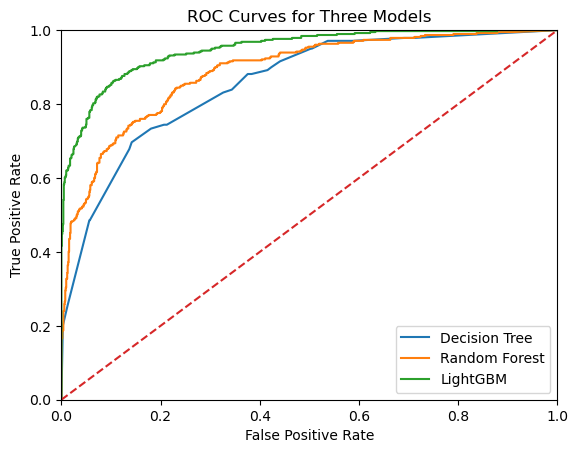

In [25]:
# Use best performing models for probability testing
# Plot ROC curve
probabilities_tree = best_tree_model.predict_proba(features_test)
predictions_tree = probabilities_tree[:, 1]
probabilities_forest = best_forest_model.predict_proba(features_test)
predictions_forest = probabilities_forest[:, 1]
probabilities_gbm = best_gbm_model.predict_proba(features_gbm_test)
predictions_gbm = probabilities_gbm[:, 1]
fpr1, tpr1, thresholds = roc_curve(target_test, predictions_tree)
fpr2, tpr2, thresholds = roc_curve(target_test, predictions_forest)
fpr3, tpr3, thresholds = roc_curve(target_gbm_test, predictions_gbm)
plt.figure()
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)

# Sanity check line (representing random guess model)
plt.plot([0, 1], [0, 1], linestyle='--')

# Cleaning and labeling
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Three Models')
plt.legend(eval_df.index)

plt.show()

## Conclusion

In this notebook we trained three models to predict user churn rate, with their demographic and service plan information as input features. We found that a gradient boosting model performed best over more classic decision tree modeling, with an AUC-ROC of .8766.

We may now address some of the concerns and matters brought up at the end of the EDA notebook. We handled class imbalance by setting the class_weight parameter for each model to 'balanced.' Our special encoding of the 'Type' feature to try to capture some trends we observed in the EDA did not elevate the decision tree models to especially high performance. The gradient boosting effect far better captured differences in classes. 

During this process we had to iterate down the LightGBMClassifier training multiple times to prevent memory overflow issues. We wanted to avoid alternative grid search methods (such as RandomizedSearchCV) to ensure we captured the best hyperparameters -- so we simply tried smaller hyperparameter sets and lowered the parallel jobs from -1 (i.e. max) to 4. This solved our memory issues.